**Research paper**:https://arxiv.org/pdf/1505.04597

In [1]:
import glob
import cv2
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random

# **Readthis first**

first  download three files:(just check current  directory i ahve upload all these three files here)<br>
1=**train-volume.tif**<br>
2=**train-labels.tif**<br>
3=**test-volume.tif**,<br>then make a folder name **ISBI2012**(in root directory),then add all these three files in that folder

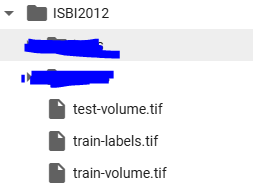

# **Config**

In [2]:
def mkdir(*paths):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)

ROOT_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_DIR = os.path.join(ROOT_DIR, 'ISBI2012')
CKPT_DIR = os.path.join(ROOT_DIR, 'checkpoints')
LOG_DIR = os.path.join(ROOT_DIR, 'logs')
TRAIN_LOG_DIR = os.path.join(LOG_DIR, 'train')
VAL_LOG_DIR = os.path.join(LOG_DIR, 'val')

IMGS_DIR = os.path.join(DATA_DIR, 'imgs')
LABELS_DIR = os.path.join(DATA_DIR, 'labels')

TRAIN_IMGS_DIR = os.path.join(IMGS_DIR, 'train')
VAL_IMGS_DIR = os.path.join(IMGS_DIR, 'val')
TEST_IMGS_DIR = os.path.join(IMGS_DIR, 'test')

TRAIN_LABELS_DIR = os.path.join(LABELS_DIR, 'train')
VAL_LABELS_DIR = os.path.join(LABELS_DIR, 'val')
TEST_LABELS_DIR = os.path.join(LABELS_DIR, 'test')

mkdir(
    CKPT_DIR, LOG_DIR, TRAIN_LOG_DIR, VAL_LOG_DIR,
    IMGS_DIR, LABELS_DIR, TRAIN_IMGS_DIR, VAL_IMGS_DIR, TEST_IMGS_DIR,
    TRAIN_LABELS_DIR, VAL_LABELS_DIR, TEST_LABELS_DIR,
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
class Config:
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 2
    NUM_EPOCHS = 100

# **Data preprocess**

**Load Data**

In [3]:
train_img_path = os.path.join(DATA_DIR, 'train-volume.tif')
train_label_path = os.path.join(DATA_DIR, 'train-labels.tif')

train_imgs = Image.open(train_img_path)
train_labels = Image.open(train_label_path)

**Split Files**

In [4]:
data_list = list()

for n in range(train_imgs.n_frames):
    train_imgs.seek(n)
    train_labels.seek(n)

    train_img = np.asarray(train_imgs)
    train_label = np.asarray(train_labels)

    data_list.append((train_img, train_label))

# Shuffle and Split Data
random.shuffle(data_list)
train_list = data_list[:24]
val_list = data_list[24:27]
test_list = data_list[27:]

**Save splitted files**

In [5]:
for idx, data in enumerate(train_list, 1):
    img, label = data
    img_dst = os.path.join(TRAIN_IMGS_DIR, f'{idx:02}.png')
    label_dst = os.path.join(TRAIN_LABELS_DIR, f'{idx:02}.png')
    cv2.imwrite(img_dst, img)
    cv2.imwrite(label_dst, label)

for idx, data in enumerate(val_list, 1):
    img, label = data
    img_dst = os.path.join(VAL_IMGS_DIR, f'{idx:02}.png')
    label_dst = os.path.join(VAL_LABELS_DIR, f'{idx:02}.png')
    cv2.imwrite(img_dst, img)
    cv2.imwrite(label_dst, label)

for idx, data in enumerate(test_list, 1):
    img, label = data
    img_dst = os.path.join(TEST_IMGS_DIR, f'{idx:02}.png')
    label_dst = os.path.join(TEST_LABELS_DIR, f'{idx:02}.png')
    cv2.imwrite(img_dst, img)
    cv2.imwrite(label_dst, label)

# **Dataset**

In [6]:
__all__ = ['Dataset', 'ToTensor', 'GrayscaleNormalization', 'RandomFlip']

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, labels_dir, transform=None):
        self.transform = transform
        self.imgs = sorted(glob.glob(os.path.join(imgs_dir, '*.png')))
        self.labels = sorted(glob.glob(os.path.join(labels_dir, '*.png')))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = cv2.imread(self.imgs[index], cv2.IMREAD_GRAYSCALE) / 255.
        label = cv2.imread(self.labels[index], cv2.IMREAD_GRAYSCALE) / 255.

        ret = {
            'img': img[:, :, np.newaxis],
            'label': label[:, :, np.newaxis],
        }

        if self.transform:
            ret = self.transform(ret)

        return ret

In [8]:
class ToTensor:
    def __call__(self, data):
        img, label = data['img'], data['label']

        img = img.transpose(2, 0, 1).astype(np.float32)  # torch 의 경우 (C, H, W)
        label = label.transpose(2, 0, 1).astype(np.float32)

        ret = {
            'img': torch.from_numpy(img),
            'label': torch.from_numpy(label),
        }
        return ret

In [9]:
class GrayscaleNormalization:
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        img, label = data['img'], data['label']
        img = (img - self.mean) / self.std

        ret = {
            'img': img,
            'label': label,
        }
        return ret

In [10]:
class RandomFlip:
    def __call__(self, data):
        img, label = data['img'], data['label']

        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            label = np.fliplr(label)

        if np.random.rand() > 0.5:
            img = np.flipud(img)
            label = np.flipud(label)

        ret = {
            'img': img,
            'label': label,
        }
        return ret

# **Utils**

In [11]:
__all__ = ['to_numpy', 'denormalization', 'classify_class', 'save_net', 'load_net']

In [12]:
def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy().transpose(0, 2, 3, 1)  # (Batch, H, W, C)

def denormalization(data, mean, std):
    return (data * std) + mean

def classify_class(x):
    return 1.0 * (x > 0.5)

def save_net(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save(
        {'net': net.state_dict(),'optim': optim.state_dict()},
        os.path.join(ckpt_dir, f'model_epoch{epoch:04}.pth'),
    )

def load_net(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_list = os.listdir(ckpt_dir)
    ckpt_list.sort(key=lambda fname: int(''.join(filter(str.isdigit, fname))))

    ckpt_path = os.path.join(CKPT_DIR, ckpt_list[-1])
    model_dict = torch.load(ckpt_path)
    print(f'* Load {ckpt_path}')

    net.load_state_dict(model_dict['net'])
    optim.load_state_dict(model_dict['optim'])
    epoch = int(''.join(filter(str.isdigit, ckpt_list[-1])))

    return net, optim, epoch


# **MODEL**

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
            )

        # Bottom-Up
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Top-Down
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.upconv4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.upconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.upconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        # out_channels = category 갯수
        self.conv1x1 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # Decoder
        dec5_1 = self.dec5_1(enc5_1)

        upconv4 = self.upconv4(dec5_1)
        cat4 = torch.cat((upconv4, enc4_2), dim=1)  # dim={0: batch, 1: channel, 2: height, 3: width}
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        upconv3 = self.upconv3(dec4_1)
        cat3 = torch.cat((upconv3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        upconv2 = self.upconv2(dec3_1)
        cat2 = torch.cat((upconv2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        upconv1 = self.upconv1(dec2_1)
        cat1 = torch.cat((upconv1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.conv1x1(dec1_1)
        return x

# **Training**

In [14]:
cfg = Config()
train_transform = transforms.Compose([
    GrayscaleNormalization(mean=0.5, std=0.5),
    RandomFlip(),
    ToTensor(),
])
val_transform = transforms.Compose([
    GrayscaleNormalization(mean=0.5, std=0.5),
    ToTensor(),
])

# Set Dataset
train_dataset = Dataset(imgs_dir=TRAIN_IMGS_DIR, labels_dir=TRAIN_LABELS_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0)
val_dataset = Dataset(imgs_dir=VAL_IMGS_DIR, labels_dir=VAL_LABELS_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0)

train_data_num = len(train_dataset)
val_data_num = len(val_dataset)

train_batch_num = int(np.ceil(train_data_num / cfg.BATCH_SIZE)) # np.ceil 반올림
val_batch_num = int(np.ceil(val_data_num / cfg.BATCH_SIZE))

# Network
net = UNet().to(device)

# Loss Function
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Optimizer
optim = torch.optim.Adam(params=net.parameters(), lr=cfg.LEARNING_RATE)

# Tensorboard
train_writer = SummaryWriter(log_dir=TRAIN_LOG_DIR)
val_writer = SummaryWriter(log_dir=VAL_LOG_DIR)

# Training
start_epoch = 0
# Load Checkpoint File
if os.listdir(CKPT_DIR):
    net, optim, start_epoch = load_net(ckpt_dir=CKPT_DIR, net=net, optim=optim)
else:
    print('* Training from scratch')

num_epochs = cfg.NUM_EPOCHS
for epoch in range(start_epoch+1, num_epochs+1):
    net.train()  # Train Mode
    train_loss_arr = list()

    for batch_idx, data in enumerate(train_loader, 1):
        # Forward Propagation
        img = data['img'].to(device)
        label = data['label'].to(device)

        output = net(img)

        # Backward Propagation
        optim.zero_grad()

        loss = loss_fn(output, label)
        loss.backward()

        optim.step()

        # Calc Loss Function
        train_loss_arr.append(loss.item())
        print_form = '[Train] | Epoch: {:0>4d} / {:0>4d} | Batch: {:0>4d} / {:0>4d} | Loss: {:.4f}'
        print(print_form.format(epoch, num_epochs, batch_idx, train_batch_num, train_loss_arr[-1]))

        # Tensorboard
        img = to_numpy(denormalization(img, mean=0.5, std=0.5))
        label = to_numpy(label)
        output = to_numpy(classify_class(output))

        global_step = train_batch_num * (epoch-1) + batch_idx
        train_writer.add_image(tag='img', img_tensor=img, global_step=global_step, dataformats='NHWC')
        train_writer.add_image(tag='label', img_tensor=label, global_step=global_step, dataformats='NHWC')
        train_writer.add_image(tag='output', img_tensor=output, global_step=global_step, dataformats='NHWC')

    train_loss_avg = np.mean(train_loss_arr)
    train_writer.add_scalar(tag='loss', scalar_value=train_loss_avg, global_step=epoch)

    # Validation (No Back Propagation)
    with torch.no_grad():
        net.eval()  # Evaluation Mode
        val_loss_arr = list()

        for batch_idx, data in enumerate(val_loader, 1):
            # Forward Propagation
            img = data['img'].to(device)
            label = data['label'].to(device)

            output = net(img)

            # Calc Loss Function
            loss = loss_fn(output, label)
            val_loss_arr.append(loss.item())

            print_form = '[Validation] | Epoch: {:0>4d} / {:0>4d} | Batch: {:0>4d} / {:0>4d} | Loss: {:.4f}'
            print(print_form.format(epoch, num_epochs, batch_idx, val_batch_num, val_loss_arr[-1]))

            # Tensorboard
            img = to_numpy(denormalization(img, mean=0.5, std=0.5))
            label = to_numpy(label)
            output = to_numpy(classify_class(output))

            global_step = val_batch_num * (epoch-1) + batch_idx
            val_writer.add_image(tag='img', img_tensor=img, global_step=global_step, dataformats='NHWC')
            val_writer.add_image(tag='label', img_tensor=label, global_step=global_step, dataformats='NHWC')
            val_writer.add_image(tag='output', img_tensor=output, global_step=global_step, dataformats='NHWC')

    val_loss_avg = np.mean(val_loss_arr)
    val_writer.add_scalar(tag='loss', scalar_value=val_loss_avg, global_step=epoch)

    print_form = '[Epoch {:0>4d}] Training Avg Loss: {:.4f} | Validation Avg Loss: {:.4f}'
    print(print_form.format(epoch, train_loss_avg, val_loss_avg))

    save_net(ckpt_dir=CKPT_DIR, net=net, optim=optim, epoch=epoch)

train_writer.close()
val_writer.close()

* Training from scratch
[Train] | Epoch: 0001 / 0100 | Batch: 0001 / 0012 | Loss: 0.6964
[Train] | Epoch: 0001 / 0100 | Batch: 0002 / 0012 | Loss: 0.5704
[Train] | Epoch: 0001 / 0100 | Batch: 0003 / 0012 | Loss: 0.5351
[Train] | Epoch: 0001 / 0100 | Batch: 0004 / 0012 | Loss: 0.4689
[Train] | Epoch: 0001 / 0100 | Batch: 0005 / 0012 | Loss: 0.4519
[Train] | Epoch: 0001 / 0100 | Batch: 0006 / 0012 | Loss: 0.4740
[Train] | Epoch: 0001 / 0100 | Batch: 0007 / 0012 | Loss: 0.4378
[Train] | Epoch: 0001 / 0100 | Batch: 0008 / 0012 | Loss: 0.4393
[Train] | Epoch: 0001 / 0100 | Batch: 0009 / 0012 | Loss: 0.4187
[Train] | Epoch: 0001 / 0100 | Batch: 0010 / 0012 | Loss: 0.4032
[Train] | Epoch: 0001 / 0100 | Batch: 0011 / 0012 | Loss: 0.3817
[Train] | Epoch: 0001 / 0100 | Batch: 0012 / 0012 | Loss: 0.3794
[Validation] | Epoch: 0001 / 0100 | Batch: 0001 / 0002 | Loss: 0.5737
[Validation] | Epoch: 0001 / 0100 | Batch: 0002 / 0002 | Loss: 0.5614
[Epoch 0001] Training Avg Loss: 0.4714 | Validation Avg 

# **Evalution**

In [15]:
# Evaluation
# 1. Delete RandomFlip
# 2. shuffle=False
# 3. Tensorboard 사용 X
# 4. Train X (Epoch 존재하지 않음)

cfg = Config()
transform = transforms.Compose([
    GrayscaleNormalization(mean=0.5, std=0.5),
    ToTensor(),
])

RESULTS_DIR = os.path.join(ROOT_DIR, 'test_results')
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

test_dataset = Dataset(imgs_dir=TEST_IMGS_DIR, labels_dir=TEST_LABELS_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0)

test_data_num = len(test_dataset)
test_batch_num = int(np.ceil(test_data_num / cfg.BATCH_SIZE)) # np.ceil 반올림

# Network
net = UNet().to(device)

# Loss Function
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Optimizer
optim = torch.optim.Adam(params=net.parameters(), lr=cfg.LEARNING_RATE)

start_epoch = 0

# Load Checkpoint File
if os.listdir(CKPT_DIR):
    net, optim, _ = load_net(ckpt_dir=CKPT_DIR, net=net, optim=optim)

# Evaluation
with torch.no_grad():
    net.eval()  # Evaluation Mode
    loss_arr = list()

    for batch_idx, data in enumerate(test_loader, 1):
        # Forward Propagation
        img = data['img'].to(device)
        label = data['label'].to(device)

        output = net(img)

        # Calc Loss Function
        loss = loss_fn(output, label)
        loss_arr.append(loss.item())

        print_form = '[Test] | Batch: {:0>4d} / {:0>4d} | Loss: {:.4f}'
        print(print_form.format(batch_idx, test_batch_num, loss_arr[-1]))

        # Tensorboard
        img = to_numpy(denormalization(img, mean=0.5, std=0.5))
        label = to_numpy(label)
        output = to_numpy(classify_class(output))

        for j in range(label.shape[0]):
            crt_id = int(test_batch_num * (batch_idx - 1) + j)

            plt.imsave(os.path.join(RESULTS_DIR, f'img_{crt_id:04}.png'), img[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(RESULTS_DIR, f'label_{crt_id:04}.png'), label[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(RESULTS_DIR, f'output_{crt_id:04}.png'), output[j].squeeze(), cmap='gray')

print_form = '[Result] | Avg Loss: {:0.4f}'
print(print_form.format(np.mean(loss_arr)))

<ipython-input-12-eb2f52f3cd1a>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(ckpt_path)


* Load /content/checkpoints/model_epoch0100.pth
[Test] | Batch: 0001 / 0002 | Loss: 0.2564
[Test] | Batch: 0002 / 0002 | Loss: 0.2443
[Result] | Avg Loss: 0.2504


**Check the result from downloaded pics(in test _results folder)**